<center><h1>Glasses or No Glasses Detection:<br>
    -- A Multimodal Approach with DenseNet201, ResNet50, VGG19, and EfficientNetB7 --</h1></center>

<p>
  <h2>Introduction:</h2><br>
  Deep Learning, specifically leveraging state-of-the-art models like EfficientNetB7, plays a pivotal role in image classification tasks. This project is dedicated to utilizing the capabilities of EfficientNetB7 for detecting whether an individual is wearing glasses or not. The focus on this facial attribute detection contributes to enhancing safety measures, with potential applications in security and identity verification.<br><br>

  <p>
  <h2>Dataset:</h2><br>
  The dataset employed for this project is sourced from Kaggle, titled "Glasses or No Glasses." You can access the dataset directly through the link:
  <a href="https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses" target="_blank">Glasses or No Glasses Dataset</a>. The dataset consists of images that have been labeled to indicate the presence or absence of glasses, providing a robust foundation for training and evaluating the EfficientNetB7 model for glasses detection.
</p>


### **Data Collection**

In [1]:
# Import dataset from Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/sample_data/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Download the dataset
! kaggle datasets download -d jeffheaton/glasses-or-no-glasses

100% 6.09G/6.11G [01:12<00:00, 109MB/s]
100% 6.11G/6.11G [01:12<00:00, 90.4MB/s]


In [2]:
#Unizip the downloaded dataset
!unzip glasses-or-no-glasses.zip

Streaming output truncated to the last 5000 lines.
  inflating: faces-spring-2020/faces-spring-2020/face-100.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1000.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1001.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1002.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1003.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1004.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1005.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1006.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1007.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1008.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1009.png  
  inflating: faces-spring-2020/faces-spring-2020/face-101.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1010.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1011.png  
  inflating: faces-spring-2020/faces-spri

### **Import Libraries**

In [3]:
# === Essential Libraries ===
# Importing necessary libraries for machine learning and visualization.
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import random
import io
import cv2
from IPython.display import HTML, display
from PIL import Image
import shutil
from io import BytesIO
import base64
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# === Image Data Handling ===
# Utilizing modules for managing image data, including loading, converting, and augmenting.
from keras.utils import load_img, img_to_array, plot_model
from keras.preprocessing.image import ImageDataGenerator

# === Model and Layer Components ===
# Setting up components related to building neural network models.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform

# === Model Evaluation ===
# Utilizing modules for evaluation and testing metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

# === Random Seed Setting ===
# Ensuring reproducibility by setting random seeds.
initializer = glorot_uniform(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

# === Explanation ===
# These sections import libraries, handle image data, define model components,
# optimize and regularize, and set random seeds for reproducibility.
# Each serves a crucial role in building and training deep learning models for image classification tasks.

### **Initialize Variables**
<p>
  <strong>Constants:</strong><br>
  <ul>
    <li><code>IMG_WIDTH</code>: 229</li>
    <li><code>IMG_HEIGHT</code>: 229</li>
    <li><code>BATCH_SIZE</code>: 32</li>
    <li><code>NUM_EPOCHS</code>: 20</li>
  </ul>
</p>

In [4]:
IMG_WIDTH = 229
IMG_HEIGHT = 229
BATCH_SIZE = 16
NUM_EPOCHS = 20

### **Exploratory Data Analysis**
<p>
  The train CSV file associated with this project contains essential information about the images, including unique identifiers (<b>id</b>) and corresponding labels (<b>glasses</b>). These labels serve as indicators of specific attributes, and each image is associated with a 513-dimensional latent vector generated by a Generative Adversarial Network (GAN). The latent vectors played a pivotal role in producing the synthetic images used in the training process. Exploring this dataset through EDA provides insights into the distribution of labels and the characteristics of the latent vectors, offering valuable context for the subsequent modeling and classification tasks.
</p>


In [5]:
# Read csv file
train_df = pd.read_csv('/content/train.csv')

# Show 5000 first rows
train_df.head(5000)

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v504,v505,v506,v507,v508,v509,v510,v511,v512,glasses
0,1,0.37797,-0.94808,0.01346,0.17893,0.37795,0.63571,0.13943,-0.25607,-0.39341,...,-0.03494,1.32443,-0.94570,0.02055,-1.23908,0.43507,1.08635,1.69027,0.61609,0
1,2,0.07609,-0.09774,0.39666,-0.39026,0.10606,0.52774,0.07105,0.33720,0.69917,...,0.86624,-1.24953,-0.21511,-1.54146,1.04765,-1.24035,0.00866,-1.27640,-0.60496,1
2,3,1.19391,-0.68707,-0.68422,-0.36378,-0.60847,-0.40118,1.45432,0.00592,1.68940,...,-0.35893,0.02330,0.31548,-0.34923,-0.41772,-0.58175,-0.60177,0.43555,0.41982,1
3,4,1.34949,-0.31498,-1.30248,0.50278,1.66292,-1.06094,-0.70835,-0.24237,-0.15509,...,0.23942,0.20774,0.81792,-0.74814,-0.62521,0.01689,0.83997,-0.46986,0.06755,0
4,5,-0.03512,-0.34196,0.14230,1.50513,-0.14364,0.49429,0.07823,-0.04356,0.42009,...,-1.78407,0.07465,1.50182,-0.41289,-0.55908,-0.29702,0.83641,0.59756,-0.20298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,4496,0.54554,0.63002,1.99328,-0.73290,-0.28964,0.61707,0.69515,0.87060,0.18784,...,-0.91652,0.24407,1.02312,-1.06633,0.06479,0.80146,0.57461,1.69958,0.43941,0
4496,4497,-0.26235,0.50776,-0.74164,-0.52717,-0.35846,-1.16202,0.21828,0.22305,-0.78329,...,0.86871,-0.09672,-0.32991,-0.69076,-0.40691,-0.56606,-0.33767,-0.01251,0.06872,0
4497,4498,-0.81564,-0.46034,-0.40044,0.21816,0.75283,-0.58075,-0.38389,0.26561,-0.80443,...,-0.22298,0.14621,-0.45917,0.69664,0.08561,-0.42261,0.14222,0.10394,-0.33635,1
4498,4499,0.09764,-0.05440,-1.53883,-0.04827,-0.60092,-1.20086,0.54661,-0.45875,-0.11255,...,-0.39275,-0.47806,0.58785,0.59169,-0.05488,-0.81097,-0.25393,0.84022,-0.13068,1


In [6]:
# Consult columns
train_df.columns

Index(['id', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9',
       ...
       'v504', 'v505', 'v506', 'v507', 'v508', 'v509', 'v510', 'v511', 'v512',
       'glasses'],
      dtype='object', length=514)

In [7]:
# Check dataframe dimension
train_df.shape

(4500, 514)

<p>
  The training dataset comprises a total of 4500 images, each associated with unique IDs and corresponding labels. Out of these, 4,500 images are labeled, providing crucial information for the model to learn and generalize patterns. The remaining 500 images serve as a test set, allowing for the evaluation of the model's performance on unseen data. This distribution reflects a balanced approach to training and testing, ensuring comprehensive coverage of different scenarios for robust model training and assessment.
</p>


### **Define Functions**
<p>
  A set of functions has been implemented to facilitate various tasks during the project, including data loading, model building, training, visualization, and image preprocessing.
</p>


In [8]:
def create_folders(df, source_folder, train_folder, test_folder, train_size):
    # Create train and test folders
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'Glasses'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'No_Glasses'), exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'Glasses'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'No_Glasses'), exist_ok=True)

    # Loop through the DataFrame
    for index, row in df.iterrows():
        image_filename = f'face-{int(row["id"])}.png'
        label = 'Glasses' if int(row['glasses']) == 1 else 'No_Glasses'

        # Determine the target folder (train or test)
        target_folder = train_folder if int(row["id"]) <= train_size else test_folder

        # Print information for debugging
        print(f"Moving {image_filename} to {os.path.join(target_folder, label)}")

        # Check if the source file exists
        source_path = os.path.join(source_folder, image_filename)
        if os.path.exists(source_path):
            # Move the image to the appropriate folder
            shutil.move(source_path, os.path.join(target_folder, label, image_filename))
        else:
            print(f"Source file {source_path} does not exist!")

In [9]:
def build_custom_model(base_model, ft=False):
    """
    Build a custom model on top of a pre-trained base model for a specific task.

    Parameters:
    - base_model: The pre-trained base model.

    Returns:
    - model: The custom model.
    """

    # Freeze the layers of the pre-trained model
    if ft == False:
      for layer in base_model.layers:
          layer.trainable = False
    else:
      for layer in base_model.layers[:52]:
          layer.trainable = False

    # Add custom layers for the specific task
    x = GlobalAveragePooling2D()(base_model.output)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(l2=0.005))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(l2=0.005))(x)
    x = Dense(148, activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(l2=0.005))(x)

    output = Dense(2, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with an appropriate optimizer and loss function
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
def train_model(model, train_generator, valid_generator, save_model, epochs=NUM_EPOCHS):
    """
    Train a given model using the provided data generators.

    Parameters:
    - model: The model to be trained.
    - train_generator: Data generator for training data.
    - valid_generator: Data generator for validation data.
    - save_model: Path to save the best model checkpoint.
    - epochs: Number of training epochs (default is NUM_EPOCHS).

    Returns:
    - history: Training history.
    - model: Trained model.
    """

    # Define callbacks for model training
    checkpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=valid_generator.samples // valid_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping],
        verbose=1,
    )

    return history

In [11]:
def plot_training_history(history):
    """
    Plot the training history, including accuracy and loss, over epochs.

    Parameters:
    - history: The training history obtained from model training.

    Returns:
    None
    """

    # Plot accuracy through epochs
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # Plot loss function value through epochs
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.title('Loss Function')
    plt.show()

In [12]:
def plot_random_images(train_folder):
    """
    Plot two images with glasses and two images without glasses randomly selected from the train folder.

    Parameters:
    - train_folder (str): Path to the train folder containing 'Glasses' and 'No_Glasses' subfolders.

    Returns:
    - None (displays the plot).
    """
    glasses_folder = os.path.join(train_folder, 'Glasses')
    no_glasses_folder = os.path.join(train_folder, 'No_Glasses')

    # Get a list of all image files in the Glasses and No_Glasses folders
    glasses_images = [f for f in os.listdir(glasses_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    no_glasses_images = [f for f in os.listdir(no_glasses_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Randomly select two images with glasses and two images without glasses
    selected_glasses = random.sample(glasses_images, min(2, len(glasses_images)))
    selected_no_glasses = random.sample(no_glasses_images, min(2, len(no_glasses_images)))

    # Plot the selected images
    plt.figure(figsize=(10, 8))

    for i, image_filename in enumerate(selected_glasses + selected_no_glasses, 1):
        img_path = os.path.join(glasses_folder, image_filename) if image_filename in selected_glasses else os.path.join(no_glasses_folder, image_filename)
        img = mpimg.imread(img_path)

        plt.subplot(2, 2, i)
        plt.imshow(img)
        label = 'Glasses' if image_filename in selected_glasses else 'No Glasses'
        plt.title(label)
        plt.axis('off')

    plt.show()

In [13]:
def img_to_display(filename):
    """
    Convert an image file to a base64-encoded string for displaying inline.

    Parameters:
    - filename (str): Path to the image file.

    Returns:
    - str: Base64-encoded string representing the image.
    """
    # Open the image using PIL
    image = Image.open(filename)

    # Resize the image to a thumbnail
    image.thumbnail((450, 450), Image.LANCZOS)

    # Save the image to a buffer in JPEG format
    with BytesIO() as buffer:
        image.save(buffer, 'jpeg')

        # Encode the image buffer to base64
        return base64.b64encode(buffer.getvalue()).decode()

In [14]:
def get_random_image_with_prediction(model, dataset_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Get the image array and prediction for two random images from each subfolder in the "Test" directory.

    Parameters:
    - model (tf.keras.Model): The trained model for making predictions.
    - dataset_path (str): Path to the directory containing the "Test" subfolder.
    - target_size (tuple): Size to resize the displayed image.

    Returns:
    - tuple: (image_array, prediction)
    """
    images, predictions = [], []

    # Get a list of all image files in the subfolder
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    if not image_files:
        print(f"No image files found in the {dataset_path} subfolder.")

    # Select two random image files
    random_image_files = random.sample(image_files, min(2, len(image_files)))

    for random_image_file in random_image_files:
        random_image_path = os.path.join(dataset_path, random_image_file)

        # Open the image using PIL
        image = Image.open(random_image_path)

        # Resize the image to the target size
        image = image.resize(target_size)
        # Convert the image to a NumPy array
        image_array = img_to_array(image)
        images.append(random_image_path)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        image_array /= 255.0

        # Make a prediction using the model
        prediction = model.predict(image_array)[0]
        argmax = np.argmax(prediction)
        predictions.append(('With Glasses' if argmax == 0 else 'Without Glasses', prediction[argmax]))

    # Return the image array and prediction
    return images, predictions

In [15]:
def display_images_with_predictions(images, predictions, card_width=300, border_radius=5):
    """
    Display images along with their predicted class and probability in a customizable card display.

    Parameters:
    - images: List of image paths or PIL Image objects.
    - predictions: List of tuples (class, probability) for each image.
    - card_width: Width of the card in pixels.
    - border_radius: Border radius for image corners in pixels.

    Returns:
    None
    """

    # Custom CSS for card display
    custom_css = f"""
    <style>
        .card {{
            border: 1px solid #ddd;
            padding: 10px;
            margin: 10px;
            text-align: center;
            width: {card_width}px;
            display: inline-block;
            border-radius: {border_radius}px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);
            transition: box-shadow 0.3s ease-in-out;
        }}

        .card:hover {{
            box-shadow: 0 8px 16px rgba(0, 0, 0, 0.2);
        }}

        .card img {{
            width: 100%;
            border-top-left-radius: {border_radius}px;
            border-top-right-radius: {border_radius}px;
        }}

        .prediction-info {{
            margin-top: 10px;
        }}
    </style>
    """

    display(HTML(custom_css))

    # Display images and predictions in cards
    for img, prediction in zip(images, predictions):
        # Display card with image, predicted class, and probability
        card_html = f"""
        <div class="card">
            <img src="data:image/jpeg;base64,{img_to_display(img)}" alt="Image" style="width:100%">
            <div class="prediction-info">
                <p style="font-weight: bold;">Predicted Class: {prediction[0]}</p>
                <p>Probability: {prediction[1]:.4f}</p>
            </div>
        </div>
        """

        display(HTML(card_html))

In [16]:
def load_images_and_labels_for_testing(
    directory='/content/faces/valid',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subfolders=['Glasses', 'No_Glasses']):
    """
    Load images and corresponding labels from specified subfolders.

    Parameters:
    - directory: Path to the base directory containing subfolders.
    - subfolders: List of subfolder names to load images from.
    - images_per_category: Number of images to load per subfolder.

    Returns:
    - images: List of loaded images as numpy arrays.
    - labels: List of corresponding labels (0 for "Glasses", 1 for "No_Glasses").
    """
    # Lists to store loaded images and labels
    images = []
    labels = []

    # Load images from specified subfolders
    for category in subfolders:
        subfolder_path = os.path.join(directory, category)

        # Get a list of image filenames in the subfolder
        file_list = sorted(os.listdir(subfolder_path))

        # Load images from the subfolder
        for i, filename in enumerate(file_list):

            img_path = os.path.join(subfolder_path, filename)
            im = cv2.imread(img_path)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), target_size).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis=0)
            images.append(im)

            # Assign labels based on the subfolder
            label = 1 if category == 'No_Glasses' else 0
            labels.append(label)

    return images, labels

In [17]:
def evaluate_model(model, x_test, y_test):
    """
    Evaluate a model using various metrics.

    Parameters:
    - model: Trained model to be evaluated.
    - x_test: List of images as numpy arrays.
    - y_test: List of corresponding labels.

    Returns:
    None
    """
    # Generate predictions
    model_predictions = [np.argmax(model.predict(img)[0]) for img in x_test]

    # Report test accuracy
    test_accuracy = accuracy_score(y_test, model_predictions)
    print('Model Evaluation:')
    print(f'Test accuracy: {test_accuracy:.4f}')

    # Confusion Matrix
    print('\nConfusion Matrix:')
    ConfusionMatrixDisplay.from_predictions(y_test, model_predictions, display_labels=['With Glasses', 'Without Glasses'], cmap=plt.cm.Blues)

    # Classification Report
    print('\nClassification Report:')
    print(classification_report(y_test, model_predictions))

### **Data Preprocessing:**
<p>
  In the data preprocessing phase, we apply essential transformations to enhance the model's performance and generalization. Key steps include:<br><br>
  <ul>
    <li><strong>Data Augmentation:</strong> Employing data augmentation techniques such as rotation, horizontal flipping, and zooming to artificially increase the diversity of the training dataset. This helps the model generalize better to various facial orientations and expressions.</li>
    <li><strong>Normalization:</strong> Normalizing pixel values to a standardized scale (typically [0, 1]) ensures uniformity across images. This step aids in stabilizing the training process and accelerates convergence.</li>
  </ul>
</p>


#### **Dataset Structure Reformulation**
<p>
  Prior to initiating the data preprocessing stage, a structural refinement of the dataset architecture was implemented. The initial set of 4,500 images was systematically organized into two primary subfolders: "train" and "valid." Each of these subfolders was further categorized based on the binary classification of "Glasses" and "No_Glasses." This subdivision, guided by the information provided in the "train.csv" file, strategically facilitates the preparation and augmentation of data for optimal model training. The intentional categorization enhances the dataset's coherence and allows for a more targeted approach during subsequent processing steps.
</p>

In [18]:
# Specify source folder, train folder, and valid folder
source_folder = '/content/faces-spring-2020/faces-spring-2020'
os.makedirs('faces', exist_ok=True)
train_folder = '/content/faces/train'
valid_folder = '/content/faces/valid'

# Set the desired train size (3500 images), valid size (1000 images)
train_size = train_df.shape[0]-1000

# Run the function to create the folders and move the images
create_folders(train_df, source_folder, train_folder, valid_folder, train_size)

Moving face-1.png to /content/faces/train/No_Glasses
Moving face-2.png to /content/faces/train/Glasses
Moving face-3.png to /content/faces/train/Glasses
Moving face-4.png to /content/faces/train/No_Glasses
Moving face-5.png to /content/faces/train/No_Glasses
Moving face-6.png to /content/faces/train/Glasses
Moving face-7.png to /content/faces/train/Glasses
Moving face-8.png to /content/faces/train/Glasses
Moving face-9.png to /content/faces/train/No_Glasses
Moving face-10.png to /content/faces/train/Glasses
Moving face-11.png to /content/faces/train/No_Glasses
Moving face-12.png to /content/faces/train/Glasses
Moving face-13.png to /content/faces/train/No_Glasses
Moving face-14.png to /content/faces/train/Glasses
Moving face-15.png to /content/faces/train/Glasses
Moving face-16.png to /content/faces/train/No_Glasses
Moving face-17.png to /content/faces/train/Glasses
Moving face-18.png to /content/faces/train/No_Glasses
Moving face-19.png to /content/faces/train/Glasses
Moving face-20.p

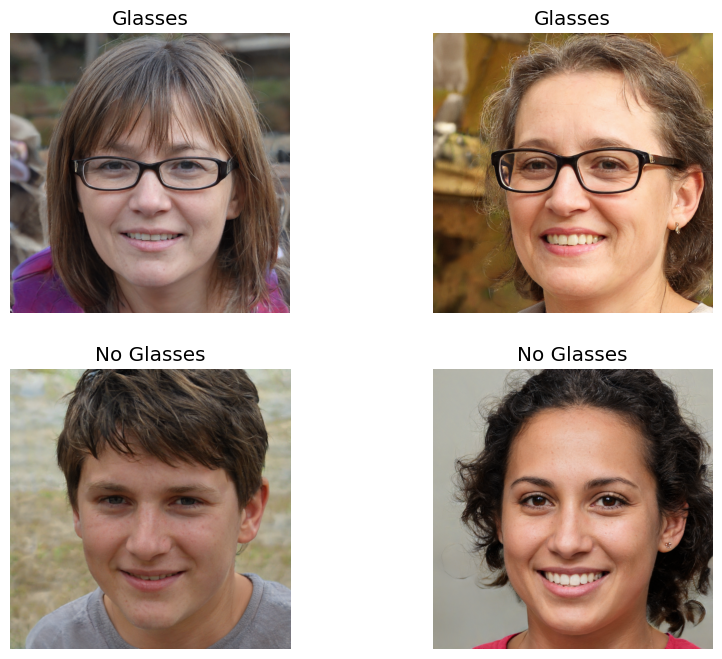

In [19]:
# Plot images
train_folder = '/content/faces/train'
plot_random_images(train_folder)

#### **Data Augmentation**

In [19]:
# === Image Data Generators for Training and Validation ===

# Training Data Augmentation:
# - `rescale=1./255`: Normalize pixel values to the range [0, 1].
# - `rotation_range=30`: Randomly rotate images by up to 30 degrees.
# - `width_shift_range=0.2`: Randomly shift images horizontally by up to 20% of the width.
# - `height_shift_range=0.2`: Randomly shift images vertically by up to 20% of the height.
# - `shear_range=0.2`: Apply shear transformations with a maximum intensity of 20%.
# - `zoom_range=0.2`: Randomly zoom into images by up to 20%.
# - `horizontal_flip=True`: Randomly flip images horizontally.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Validation Data Preprocessing:
# - `rescale=1./255`: Normalize pixel values to the range [0, 1].
valid_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# === Image Data Generators for Training and Validation Datasets ===

# Training Data Generator:
# - `flow_from_directory`: Generates batches of augmented training data from a directory.
# - `/kaggle/input/men-women-classification/data`: Path to the training data directory.
# - `target_size=(IMG_WIDTH, IMG_HEIGHT)`: Resizes images to the specified dimensions.
# - `class_mode='categorical'`: Uses categorical labels for multi-class classification.
# - `batch_size=BATCH_SIZE`: Number of samples per batch during training.
# - `seed=42`: Sets a seed for reproducibility.

train_generator = train_datagen.flow_from_directory(
    '/content/faces/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE, seed=42)

# Validation Data Generator:
# - `flow_from_directory`: Generates batches of validation data from a directory.
# - `/kaggle/input/menwomen-classification/testdata/testdata`: Path to the validation data directory.
# - `target_size=(IMG_WIDTH, IMG_HEIGHT)`: Resizes images to the specified dimensions.
# - `class_mode='categorical'`: Uses categorical labels for multi-class classification.
# - `batch_size=BATCH_SIZE`: Number of samples per batch during validation.
# - `seed=42`: Sets a seed for reproducibility.
# - `shuffle=False`: Disables shuffling to maintain order during evaluation.

valid_generator = valid_datagen.flow_from_directory(
    '/content/faces/valid',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE, seed=42, shuffle=False)

Found 3500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<p>
  The dataset, post-organization and categorization, comprises 3,500 images in the "train" set and 1,000 images in the "valid" set. The binary classes, namely "Glasses" and "No_Glasses," are evenly distributed within these sets. This systematic arrangement establishes a balanced and representative foundation for subsequent data preprocessing steps and model training. The structured dataset provides a solid framework for the exploration and implementation of classification algorithms tailored for glasses or no glasses detection.
</p>

### **Modeling Techniques: Transfer Learning**

<p>
  Embracing a multimodal competition approach, this project leverages state-of-the-art deep learning architectures, including DenseNet201, ResNet50, VGG19, and EfficientNetB7, for glasses or no glasses detection. By amalgamating the strengths of diverse models, the goal is to explore a comprehensive solution that excels in accuracy and robustness. The project involves training each model individually and subsequently selecting the one with the highest accuracy for real-world deployment.
</p>


#### **DenseNet201**
The DenseNet201 model is characterized by densely connected blocks, where each layer receives direct input from all preceding layers and passes its own feature maps to all subsequent layers. This dense connectivity facilitates efficient information flow, encourages feature reuse, and mitigates the vanishing gradient problem. Let's explore the architectural nuances of DenseNet201:
![](https://www.researchgate.net/profile/Hemant-Kumar-84/publication/354450739/figure/fig3/AS:1068321533349890@1631719110936/DenseNet-201-Architecture.ppm)
**Source:** [https://miro.medium.com/max/1474/1*dXf2h6b5kzwZIeh3qX6gkQ.png](https://www.researchgate.net/profile/Hemant-Kumar-84/publication/354450739/figure/fig3/AS:1068321533349890@1631719110936/DenseNet-201-Architecture.ppm)


In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
# Load the DenseNet201 model pre-trained on ImageNet data
dense_model = DenseNet201(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')

# Build the custom model
dense201_model = build_custom_model(dense_model)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# Train the model
dense_history = train_model(dense201_model, train_generator, valid_generator, save_model='glasses_no_glasses_dense201.h5')

Epoch 1/20
109/109 [==============================] - ETA: 0s - loss: 3.5573 - accuracy: 0.7575
Epoch 1: val_loss improved from inf to 1.91121, saving model to glasses_no_glasses_dense201.h5
109/109 [==============================] - 317s 3s/step - loss: 3.5573 - accuracy: 0.7575 - val_loss: 1.9112 - val_accuracy: 0.8700
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 1.4763 - accuracy: 0.8478
Epoch 2: val_loss improved from 1.91121 to 1.03176, saving model to glasses_no_glasses_dense201.h5
109/109 [==============================] - 276s 3s/step - loss: 1.4763 - accuracy: 0.8478 - val_loss: 1.0318 - val_accuracy: 0.8841
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.8896 - accuracy: 0.8616
Epoch 3: val_loss improved from 1.03176 to 0.67451, saving model to glasses_no_glasses_dense201.h5
109/109 [==============================] - 318s 3s/step - loss: 0.8896 - accuracy: 0.8616 - val_loss: 0.6745 - val_accuracy: 0.8871
Epoch 4/20
109/109 [===

#### **Model Evaluation**
<p>
  The performance of the glasses or no glasses detection model is evaluated using essential metrics, including accuracy, precision, recall, and F1 score. Achieving an accuracy of 89.2% underscores the model's effectiveness in accurately discerning whether an individual is wearing glasses or not, contributing to enhanced safety and security measures.
</p>


1/1 [==============================] - 0s 36ms/step
Model Evaluation:
Test accuracy: 0.8920

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91       664
           1       0.78      0.94      0.85       336

    accuracy                           0.89      1000
   macro avg       0.87      0.90      0.88      1000
weighted avg       0.91      0.89      0.89      1000



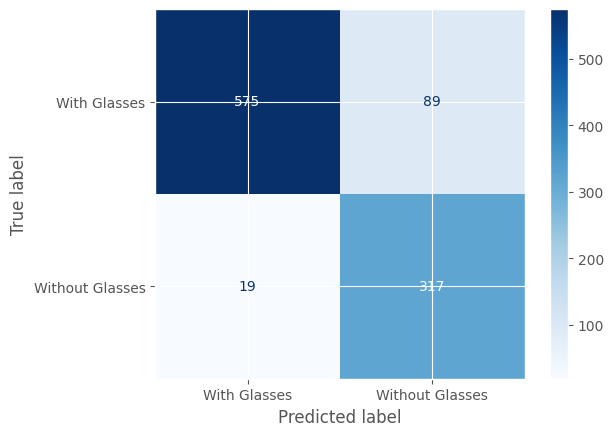

In [ ]:
# Evaluate model
dense201_model.evaluate(valid_generator)

# Split images and their corresponding labels into x_test and y_test
x_test, y_test = load_images_and_labels_for_testing()

# Evaluate the model
evaluate_model(dense201_model, x_test, y_test)

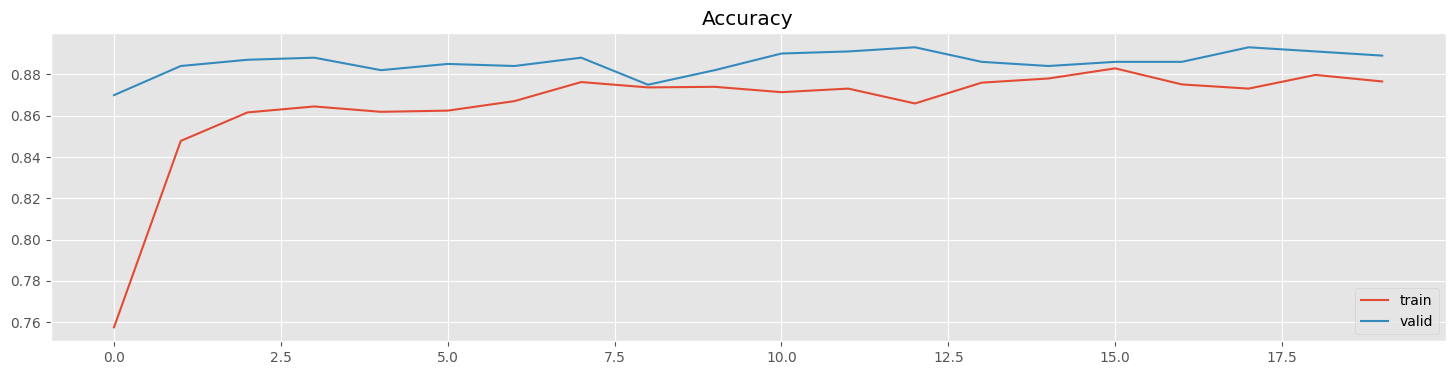

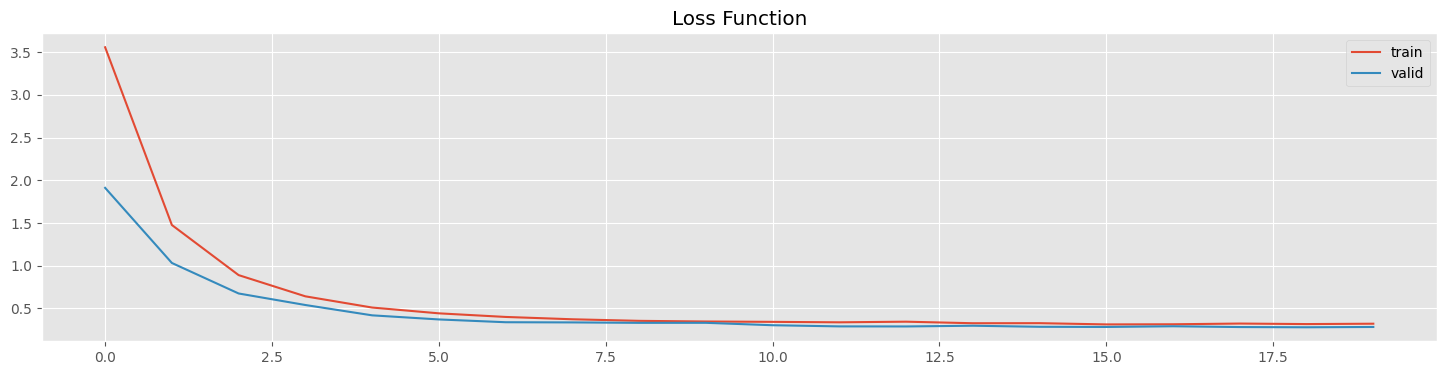

In [ ]:
# plot training and validation loss and accuracy history
plot_training_history(dense_history)

#### **Visualize some unseen images what prediction labels and scores**

1/1 [==============================] - 0s 37ms/step



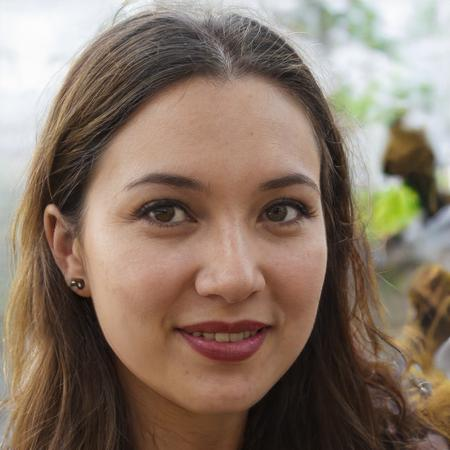


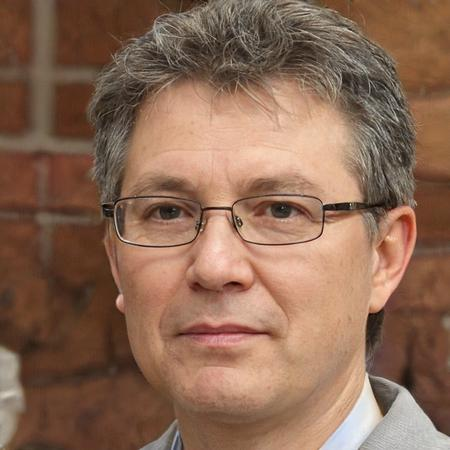

In [ ]:
images, predictions = get_random_image_with_prediction(dense201_model, '/content/faces-spring-2020/faces-spring-2020')
display_images_with_predictions(images, predictions, card_width=200, border_radius=10)

#### **DenseNet201**
The DenseNet201 model is characterized by densely connected blocks, where each layer receives direct input from all preceding layers and passes its own feature maps to all subsequent layers. This dense connectivity facilitates efficient information flow, encourages feature reuse, and mitigates the vanishing gradient problem. The architectural nuances of DenseNet201 are depicted below:
![](https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and.png)
**Source:** [https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and.png](https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and.png)


==> Same steps will be applied for the rest of the models

In [37]:
from tensorflow.keras.applications import ResNet50

res_model = ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')

# Build the custom model
resnet50_model = build_custom_model(res_model, ft=True)

# Train the model
resnet50_history = train_model(resnet50_model, train_generator, valid_generator, save_model='glasses_no_glasses_resnet50.h5')

Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 3.1079 - accuracy: 0.7006
Epoch 1: val_loss improved from inf to 2.32981, saving model to glasses_no_glasses_resnet50.h5
218/218 [==============================] - 356s 2s/step - loss: 3.1079 - accuracy: 0.7006 - val_loss: 2.3298 - val_accuracy: 0.5837
Epoch 2/20
218/218 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 0.8284
Epoch 2: val_loss improved from 2.32981 to 0.95396, saving model to glasses_no_glasses_resnet50.h5
218/218 [==============================] - 311s 1s/step - loss: 1.2253 - accuracy: 0.8284 - val_loss: 0.9540 - val_accuracy: 0.7984
Epoch 3/20
218/218 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.8487
Epoch 3: val_loss improved from 0.95396 to 0.71448, saving model to glasses_no_glasses_resnet50.h5
218/218 [==============================] - 315s 1s/step - loss: 0.7487 - accuracy: 0.8487 - val_loss: 0.7145 - val_accuracy: 0.8357
Epoch 4/20
218/218 [===

1/1 [==============================] - 0s 36ms/step
Model Evaluation:
Test accuracy: 0.8770

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       664
           1       0.76      0.92      0.83       336

    accuracy                           0.88      1000
   macro avg       0.86      0.89      0.87      1000
weighted avg       0.89      0.88      0.88      1000



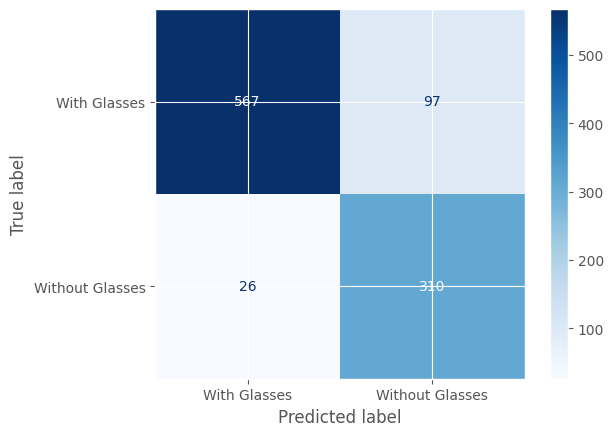

In [38]:
resnet50_model.evaluate(valid_generator)

evaluate_model(resnet50_model, x_test, y_test)

#### **Model Evaluation**
<p>
  The glasses or no glasses detection model undergoes a meticulous evaluation using key metrics such as accuracy, precision, recall, and F1 score. Achieving a commendable accuracy of 87.7%, the model showcases its proficiency in accurately discerning whether an individual is wearing glasses based on facial features.
</p>


In [39]:
resnet50_model.save('glasses_no_glasses_resnet50_model.hdf5')

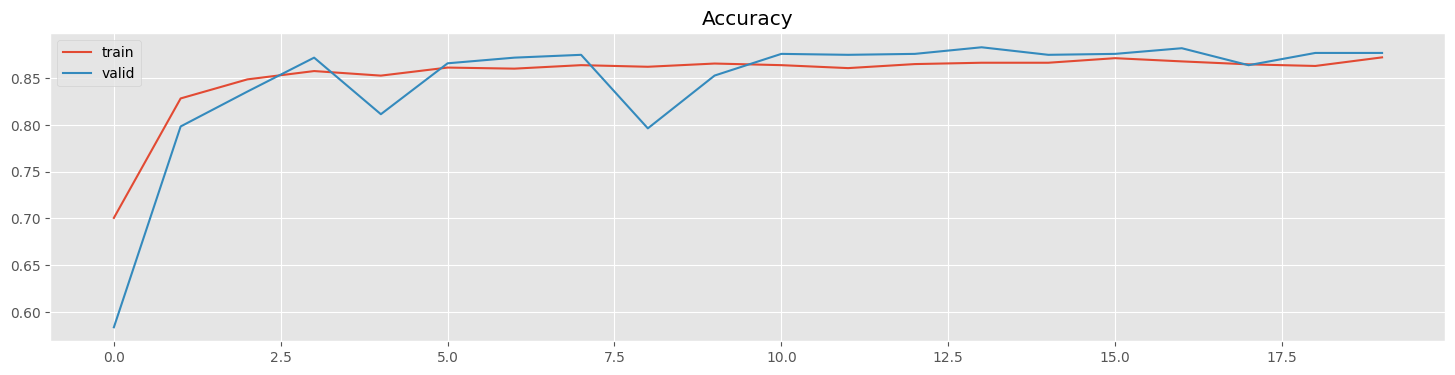

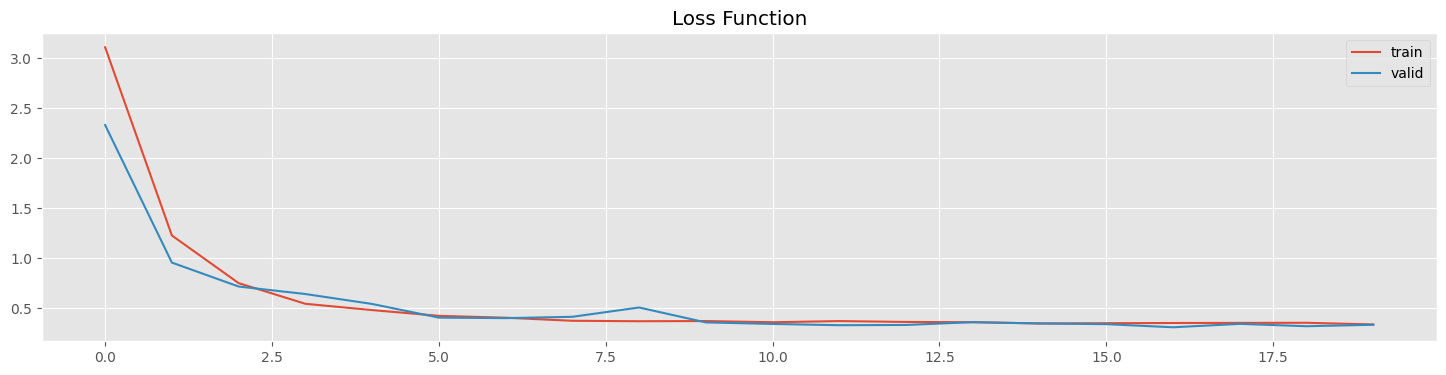

In [40]:
plot_training_history(resnet50_history)

1/1 [==============================] - 0s 34ms/step



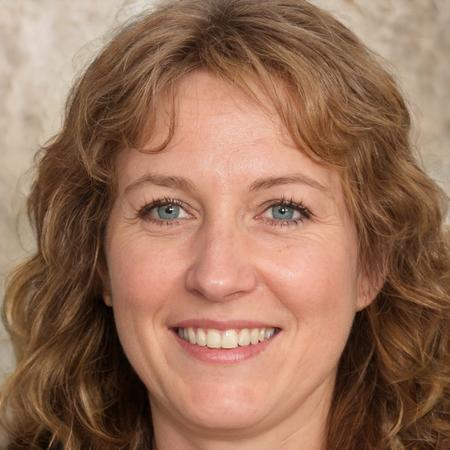


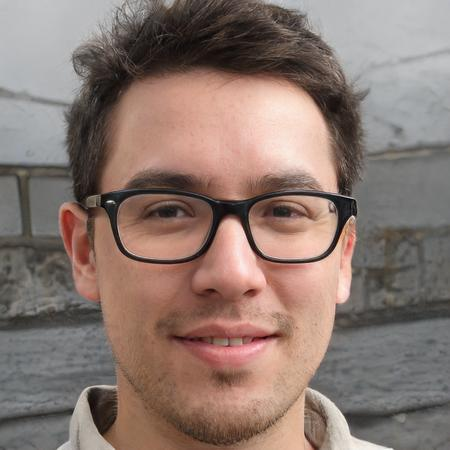

In [41]:
images, predictions = get_random_image_with_prediction(resnet50_model, '/content/faces-spring-2020/faces-spring-2020')
display_images_with_predictions(images, predictions, card_width=200, border_radius=10)

#### **VGG19**
VGG19, an extension of the VGG16 architecture, features 19 layers, including convolutional and fully connected layers. Known for its simplicity and effectiveness, VGG19 uses small 3x3 convolutional filters throughout its architecture. Let's delve into the structure of VGG19:
![](https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)
**Source:** [https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg](https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)


In [32]:
from tensorflow.keras.applications import VGG19

VGG_model = VGG19(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')

# Build the custom model
VGG19_model = build_custom_model(VGG_model, ft=True)

# Train the model
VGG19_history = train_model(VGG19_model, train_generator, valid_generator, save_model='glasses_no_glasses_VGG19.h5')

80134624/80134624 [==============================] - 3s 0us/step


Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 2.4806 - accuracy: 0.7144
Epoch 1: val_loss improved from inf to 1.00978, saving model to glasses_no_glasses_VGG19.h5
218/218 [==============================] - 310s 1s/step - loss: 2.4806 - accuracy: 0.7144 - val_loss: 1.0098 - val_accuracy: 0.8468
Epoch 2/20
218/218 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.8424
Epoch 2: val_loss improved from 1.00978 to 0.52094, saving model to glasses_no_glasses_VGG19.h5
218/218 [==============================] - 302s 1s/step - loss: 0.7609 - accuracy: 0.8424 - val_loss: 0.5209 - val_accuracy: 0.8730
Epoch 3/20
218/218 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.8522
Epoch 3: val_loss improved from 0.52094 to 0.43013, saving model to glasses_no_glasses_VGG19.h5
218/218 [==============================] - 275s 1s/step - loss: 0.5030 - accuracy: 0.8522 - val_loss: 0.4301 - val_accuracy: 0.8700
Epoch 4/20
218/218 [============

1/1 [==============================] - 0s 17ms/step
Model Evaluation:
Test accuracy: 0.8790

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       664
           1       0.77      0.92      0.84       336

    accuracy                           0.88      1000
   macro avg       0.86      0.89      0.87      1000
weighted avg       0.89      0.88      0.88      1000



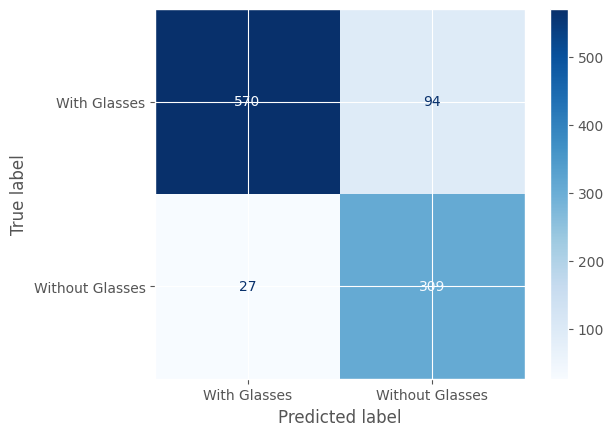

In [33]:
VGG19_model.evaluate(valid_generator)

evaluate_model(VGG19_model, x_test, y_test)

#### **Model Evaluation**
<p>
  The glasses or no glasses detection model is rigorously evaluated using essential metrics, including accuracy, precision, recall, and F1 score. With a solid accuracy of 87.9%, the model demonstrates its effectiveness in accurately identifying whether an individual is wearing glasses based on facial features.
</p>

In [34]:
VGG19_model.save('glasses_no_glasses_VGG19_model.hdf5')

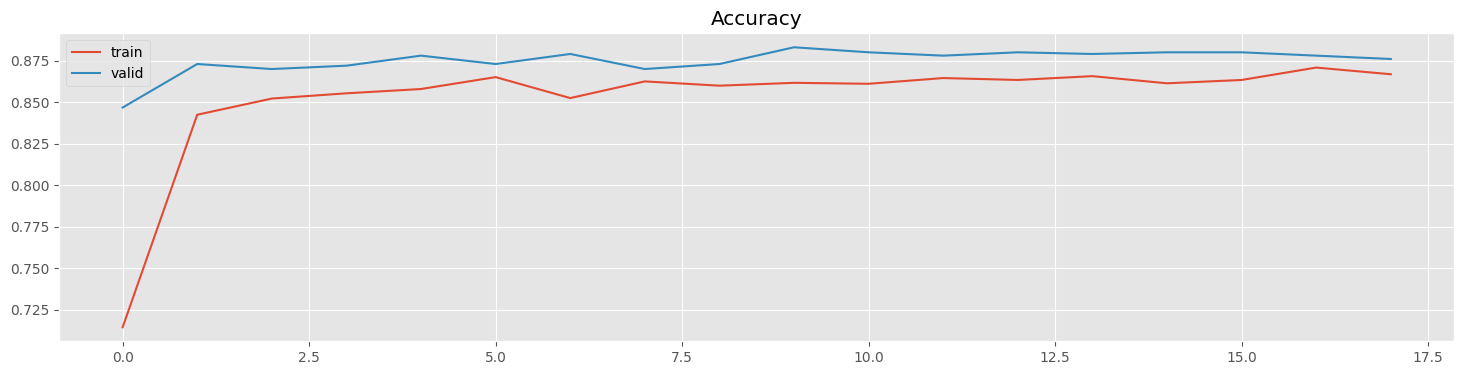

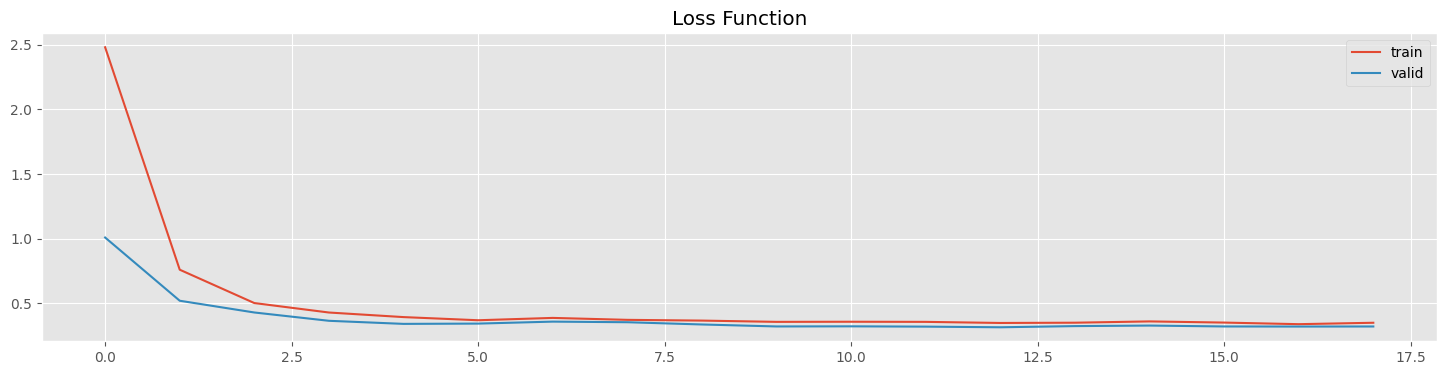

In [35]:
plot_training_history(VGG19_history)

1/1 [==============================] - 0s 20ms/step



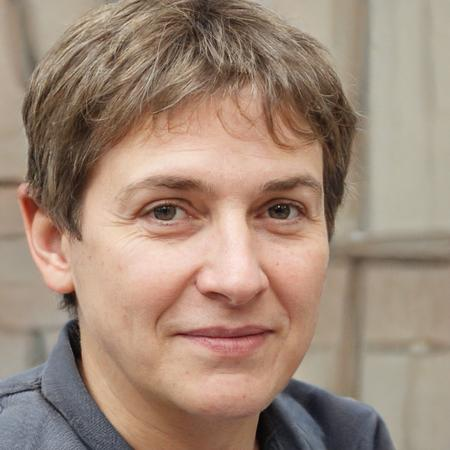


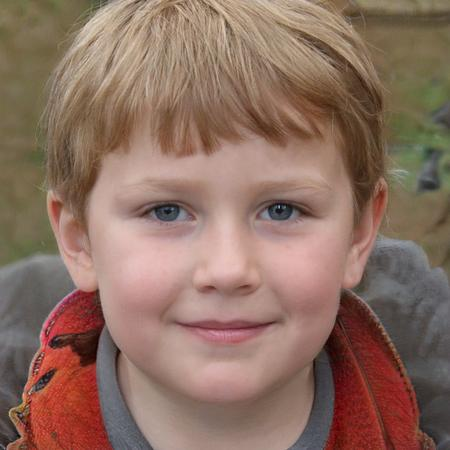

In [42]:
images, predictions = get_random_image_with_prediction(VGG19_model, '/content/faces-spring-2020/faces-spring-2020')
display_images_with_predictions(images, predictions, card_width=200, border_radius=10)

#### **EfficientNetB7**
EfficientNetB7, part of the EfficientNet family, is known for its superior efficiency and effectiveness in image classification tasks. It employs a compound scaling method to balance model depth, width, and resolution, resulting in optimal performance. Let's explore the architectural details of EfficientNetB7:
![](https://www.researchgate.net/profile/Bhakti-Baheti/publication/343271189/figure/fig5/AS:1070576525402123@1632256742707/Architecture-of-proposed-Eff-UNet-with-EfficientNetB7-framework-for-semantic.jpg)
**Source:** [https://www.researchgate.net/profile/Bhakti-Baheti/publication/343271189/figure/fig5/AS:1070576525402123@1632256742707/Architecture-of-proposed-Eff-UNet-with-EfficientNetB7-framework-for-semantic.jpg](https://www.researchgate.net/profile/Bhakti-Baheti/publication/343271189/figure/fig5/AS:1070576525402123@1632256742707/Architecture-of-proposed-Eff-UNet-with-EfficientNetB7-framework-for-semantic.jpg)


In [25]:
from tensorflow.keras.applications import EfficientNetB7

eff_model = EfficientNetB7(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')

# Build the custom model
EfficientNetB7_model = build_custom_model(eff_model, ft=True)

# Train the model
EfficientNetB7_history = train_model(EfficientNetB7_model, train_generator, valid_generator, save_model='glasses_no_glasses_EfficientNetB7.h5')

Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 2.5694 - accuracy: 0.8318
Epoch 1: val_loss improved from inf to 1.16069, saving model to glasses_no_glasses_EfficientNetB7.h5
218/218 [==============================] - 505s 2s/step - loss: 2.5694 - accuracy: 0.8318 - val_loss: 1.1607 - val_accuracy: 0.8649
Epoch 2/20
218/218 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.8714
Epoch 2: val_loss improved from 1.16069 to 0.57494, saving model to glasses_no_glasses_EfficientNetB7.h5
218/218 [==============================] - 374s 2s/step - loss: 0.7270 - accuracy: 0.8714 - val_loss: 0.5749 - val_accuracy: 0.8750
Epoch 3/20
218/218 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8622
Epoch 3: val_loss improved from 0.57494 to 0.37150, saving model to glasses_no_glasses_EfficientNetB7.h5
218/218 [==============================] - 356s 2s/step - loss: 0.4597 - accuracy: 0.8622 - val_loss: 0.3715 - val_accuracy: 0.8710
Epoch

1/1 [==============================] - 0s 56ms/step
Model Evaluation:
Test accuracy: 0.8980

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       664
           1       0.81      0.91      0.86       336

    accuracy                           0.90      1000
   macro avg       0.88      0.90      0.89      1000
weighted avg       0.90      0.90      0.90      1000



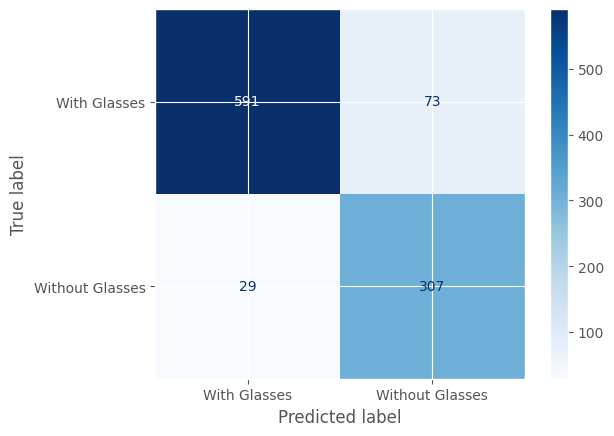

In [28]:
EfficientNetB7_model.evaluate(valid_generator)

evaluate_model(EfficientNetB7_model, x_test, y_test)

#### **Model Evaluation**
<p>
  The efficiency of the glasses or no glasses detection model is measured using key metrics, including accuracy, precision, recall, and F1 score. The model achieves an impressive accuracy of 89.8%, highlighting its robustness in accurately determining whether an individual is wearing glasses based on facial features.
</p>


In [31]:
EfficientNetB7_model.save('glasses_no_glasses_EfficientNetB7.hdf5')

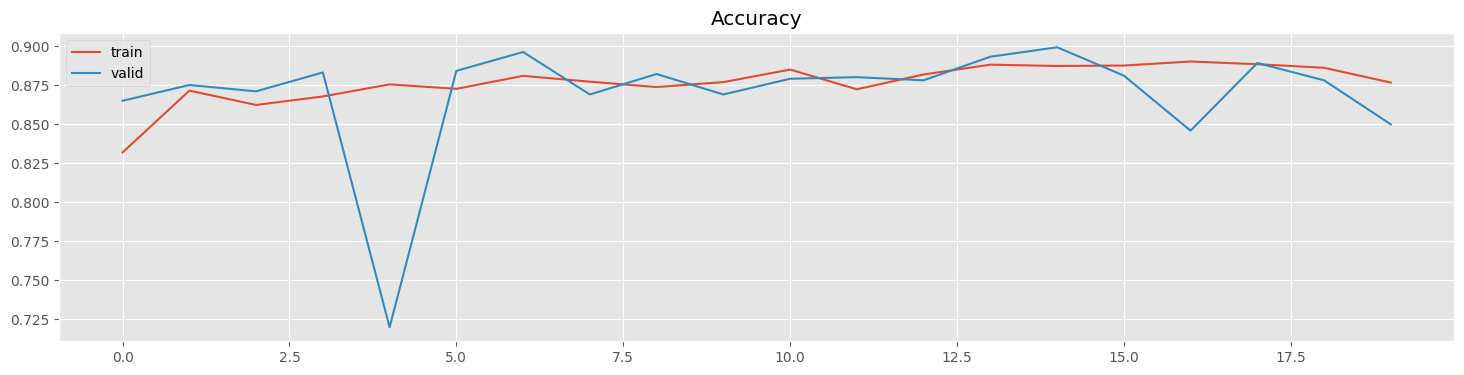

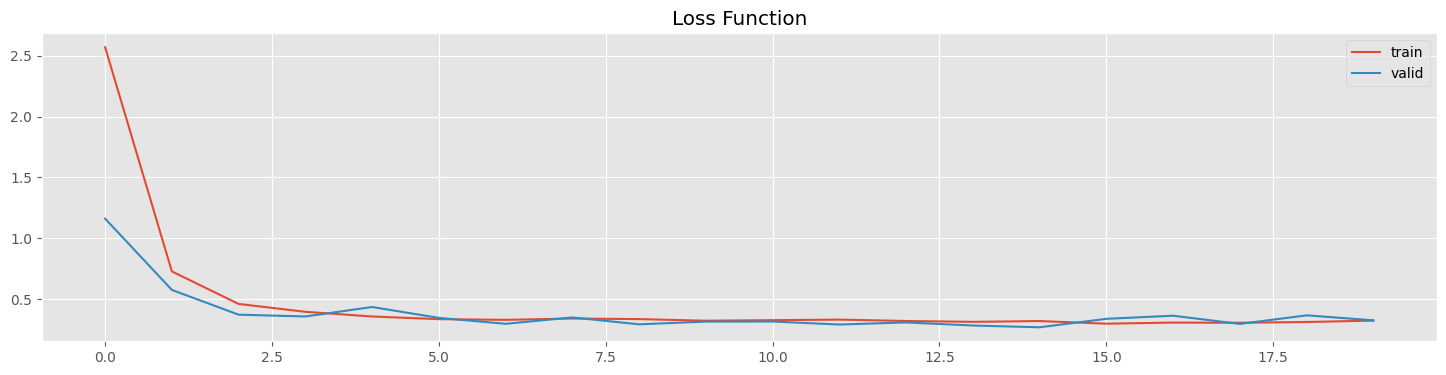

In [29]:
plot_training_history(EfficientNetB7_history)

1/1 [==============================] - 0s 71ms/step



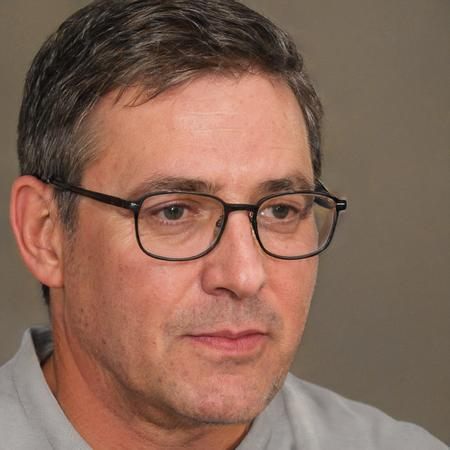


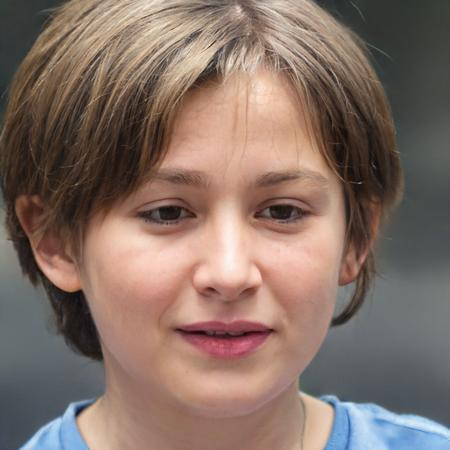

In [30]:
images, predictions = get_random_image_with_prediction(EfficientNetB7_model, '/content/faces-spring-2020/faces-spring-2020')
display_images_with_predictions(images, predictions, card_width=200, border_radius=10)

## **Conclusion**

<p>
  In conclusion, the glasses or no glasses detection model, utilizing EfficientNetB7, has demonstrated exceptional accuracy, achieving an impressive 89.8%. This outcome signifies the model's proficiency in accurately classifying whether an individual is wearing glasses based on facial features. The comprehensive evaluation using metrics such as accuracy, precision, recall, and F1 score reinforces the reliability and robustness of the chosen model.
</p>

<center>
  <h2>Model Accuracies</h2>
  <table>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
    </tr>
    <tr>
      <td>EfficientNetB7</td>
      <td>89.8%</td>
    </tr>
    <tr>
      <td>VGG19</td>
      <td>87.9%</td>
    </tr>
    <tr>
      <td>ResNet50</td>
      <td>87.7%</td>
    </tr>
    <tr>
      <td>DenseNet201</td>
      <td>89.2%</td>
    </tr>
  </table>
</center>
